In [154]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import importlib
from scipy.stats import pearsonr

from tensorflow.keras.layers import Conv2D, MaxPool2D, concatenate, Dropout, \
    Dense, Input, Flatten

from Modules import tf_utils

In [341]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize pixels
x_train, x_test = x_train / 255.0, x_test / 255.0
img_shape = (32, 32, 3)
pos_val = 0
held_out_val = 8
dset_shape = (-1,) + img_shape
# Creating training examples
mask_test = (y_test == pos_val).ravel()
mask_test_held_out = (y_test == held_out_val).ravel()
pos_samples = x_test[mask_test, :, :]
neg_samples = x_test[np.logical_not(mask_test | mask_test_held_out), :, :]
neg_samples = neg_samples[:len(pos_samples)]
my_x_test = np.concatenate((pos_samples, neg_samples), axis=0)
my_y_test = np.concatenate((np.ones(len(pos_samples)),
                            np.zeros(len(neg_samples))))
order = np.random.permutation(len(my_y_test))
my_x_test = my_x_test[order].reshape(dset_shape)
my_y_test = my_y_test[order]
# Creating training examples
mask_train = (y_train == pos_val).ravel()
mask_held_out = (y_train == held_out_val).ravel()
held_out = x_train[mask_held_out, :, :].reshape(dset_shape)
negatives = x_train[np.logical_not(mask_train | mask_held_out), :, :].reshape(dset_shape)
positives = x_train[mask_train, :, :].reshape(dset_shape)

In [342]:
base_len = min(len(positives), len(negatives))
X = np.concatenate((positives[:base_len], negatives[:base_len]))
Y = np.concatenate((np.ones(base_len, dtype=float), np.zeros(base_len, dtype=float)))
order = np.random.permutation(len(X))
X = X[order]
Y = Y[order]

1.0


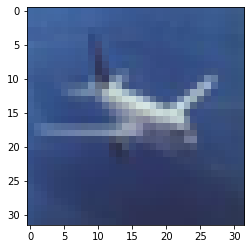

1.0


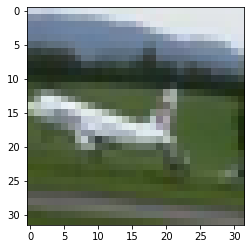

1.0


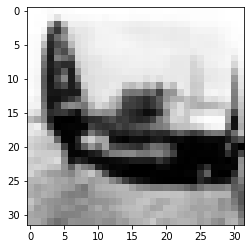

1.0


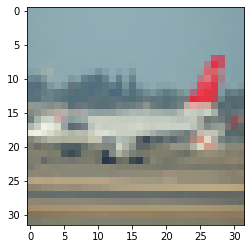

0.0


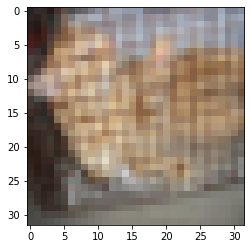

In [343]:
for i in range(5):
    print(my_y_test[i])
    plt.imshow(my_x_test[i])
    plt.show()
    plt.close()
    

In [177]:
importlib.reload(tf_utils)
# build the CNN model
input_layer = Input(shape=img_shape)

x = Conv2D(64, (4, 4), activation='relu')(input_layer)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (4, 4), activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

out = Dense(2, activation='sigmoid', name='out')(x)
# conf = Dense(1, activation='sigmoid', name='conf')(x)

model = tf.keras.Model(input_layer,
                       out,#[out, conf],
                       name='conv_confidence')
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf_utils.ConfidenceLoss(),
              metrics=['accuracy'])


In [344]:
input_layer2 = Input(shape=img_shape)

x2 = Conv2D(64, (4, 4), activation='relu')(input_layer2)
x2 = MaxPool2D((2, 2))(x2)
x2 = Dropout(0.2)(x2)

x2 = Conv2D(64, (4, 4), activation='relu')(x2)
x2 = MaxPool2D((2, 2))(x2)
x2 = Dropout(0.2)(x2)

x2 = Flatten()(x2)

x2 = Dense(128, activation='relu')(x2)
features = tf.keras.Model(input_layer2, x2, name='features')

out2 = Dense(1, activation='sigmoid', name='out')(features(input_layer2))
# conf = Dense(1, activation='sigmoid', name='conf')(x)

model2 = tf.keras.Model(input_layer2,
                        out2,#[out, conf],
                        name='conv_confidence')
# compile model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss="binary_crossentropy",#tf_utils.ConfidenceLoss(),
               metrics=['accuracy'])



In [345]:
history = model2.fit(X, Y, epochs=20, batch_size=128)

Epoch 1/20
79/79 [==============================] - 1s 3ms/step - loss: 0.5055 - accuracy: 0.7587
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 0.4108 - accuracy: 0.8200
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 0.3740 - accuracy: 0.8392
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.8615
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 0.3292 - accuracy: 0.8595
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2961 - accuracy: 0.8752
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2759 - accuracy: 0.8892
Epoch 8/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2595 - accuracy: 0.8953
Epoch 9/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2605 - accuracy: 0.8930
Epoch 10/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2517 - accuracy: 0.8967
Epoch 11/20
79/79 [

In [346]:
features.trainable = False
conf = Dense(1, activation="sigmoid", name='conf')(features(input_layer2, training=False))
conf_model = tf.keras.Model(input_layer2, conf, name='just_conf')
conf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss="mse",#tf_utils.ConfidenceLoss(),
                   metrics=['mae'])

In [347]:
pred_train2 = model2.predict(X).ravel()
# pred_test2_save = model2.predict(my_x_test).ravel()

In [348]:
history = conf_model.fit(X, np.abs(pred_train2 - Y), epochs=20, batch_size=128)

Epoch 1/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0943 - mae: 0.2736
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0250 - mae: 0.1280
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 0.0200 - mae: 0.101 - 0s 2ms/step - loss: 0.0200 - mae: 0.1002
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0187 - mae: 0.0890
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0182 - mae: 0.0835
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0180 - mae: 0.0798
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0179 - mae: 0.0779
Epoch 8/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0178 - mae: 0.0760
Epoch 9/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0177 - mae: 0.0753
Epoch 10/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0176 - mae: 0.0749
Epoch 11/20
79/79 [============

In [179]:
pred_test_full = model.predict(my_x_test)
pred_test = pred_test_full[:, 0]
pred_test

array([0.05143119, 0.82463926, 0.00865312, ..., 0.49426115, 0.98180985,
       0.01251378], dtype=float32)

In [180]:
pos_acc = np.sum((pred_test > 0.5) & (my_y_test == 1)) / np.sum(my_y_test == 1)
neg_acc = np.sum((pred_test < 0.5) & (my_y_test == 0)) / np.sum(my_y_test == 0)
print(pos_acc)
print(neg_acc)

0.897
0.833


In [181]:
pred_conf = pred_test_full[:, 1]
pred_conf

array([0.0072657 , 0.00338768, 0.00216202, ..., 0.01460166, 0.0285477 ,
       0.00178017], dtype=float32)

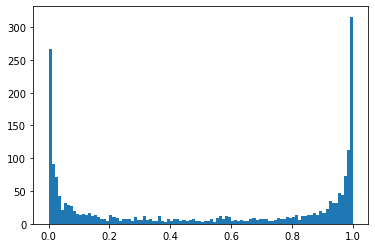

In [182]:
plt.hist(pred_test, bins=100, range=(0, 1))
plt.show()
plt.close()

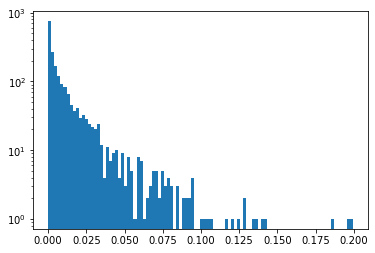

In [183]:
plt.hist(pred_conf, bins=100)
plt.yscale('log')
plt.show()
plt.close()

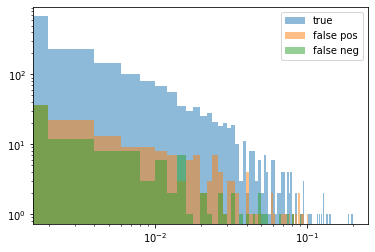

In [203]:
MAX = np.max(pred_conf)
plt.hist(pred_conf[((pred_test > 0.5) & (my_y_test == 1)) | ((pred_test < 0.5) & (my_y_test == 0))], bins=100, range=(0, MAX), label="true", alpha=0.5)
plt.hist(pred_conf[(pred_test > 0.5) & (my_y_test == 0)], bins=100, range=(0, MAX), label="false pos", alpha=0.5)
plt.hist(pred_conf[(pred_test < 0.5) & (my_y_test == 1)], bins=100, range=(0, MAX), label="false neg", alpha=0.5)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()

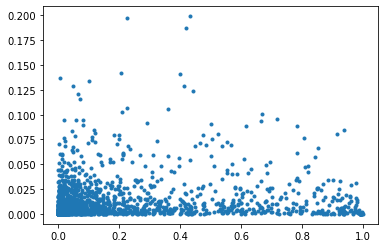

In [206]:
plt.scatter(np.abs(my_y_test - pred_test), pred_conf, marker='.')
# plt.

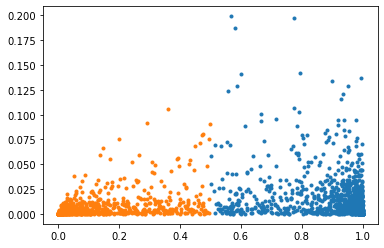

In [211]:
mask = (pred_test > 0.5)
plt.scatter(pred_test[mask], pred_conf[mask], marker='.')
mask = (pred_test < 0.5)
plt.scatter(pred_test[mask], pred_conf[mask], marker='.')

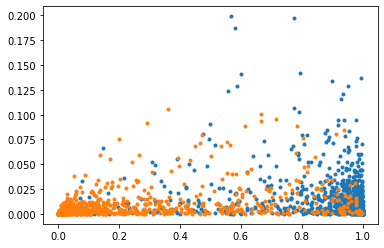

In [212]:
mask = (my_y_test == 1)
plt.scatter(pred_test[mask], pred_conf[mask], marker='.')
mask = (my_y_test == 0)
plt.scatter(pred_test[mask], pred_conf[mask], marker='.')

In [207]:
pearsonr(np.abs(my_y_test - pred_test), pred_conf)

(0.14683797240381594, 4.153826050407711e-11)

In [349]:
pred_test2 = model2.predict(my_x_test).ravel()
pred_conf2 = conf_model.predict(my_x_test).ravel()
pred_test2

array([9.9970740e-01, 9.9808723e-01, 5.0860965e-01, ..., 1.3431337e-02,
       2.2187960e-05, 8.9173651e-01], dtype=float32)

In [350]:
pred_held_out = model2.predict(held_out).ravel()
pred_held_out_conf = conf_model.predict(held_out).ravel()
pred_held_out.shape

(5000,)

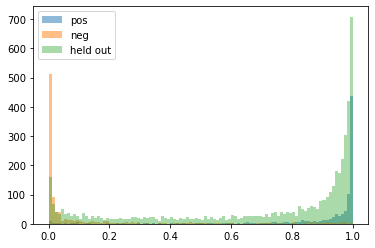

In [351]:
plt.hist(pred_test2[my_y_test == 1], bins=100, range=(0, 1), alpha=0.5, label='pos')
plt.hist(pred_test2[my_y_test == 0], bins=100, range=(0, 1), alpha=0.5, label='neg')
plt.hist(pred_held_out, bins=100, range=(0, 1), alpha=0.4, label='held out')
plt.legend()
plt.show()
plt.close()

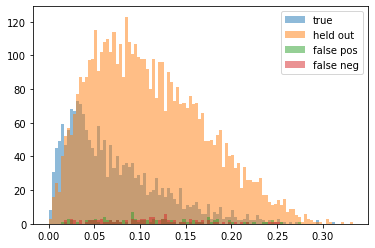

In [352]:
MAX = np.max(pred_conf2)
MAX = max(MAX, np.max(pred_held_out_conf))

plt.hist(pred_conf2[((pred_test2 > 0.5) & (my_y_test == 1)) | ((pred_test2 < 0.5) & (my_y_test == 0))], bins=100, range=(0, MAX), label="true", alpha=0.5)
plt.hist(pred_held_out_conf, bins=100, range=(0, MAX), label="held out", alpha=0.5)
plt.hist(pred_conf2[(pred_test2 > 0.5) & (my_y_test == 0)], bins=100, range=(0, MAX), label="false pos", alpha=0.5)
plt.hist(pred_conf2[(pred_test2 < 0.5) & (my_y_test == 1)], bins=100, range=(0, MAX), label="false neg", alpha=0.5)

plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()
plt.close()

In [353]:
pos_acc = np.sum((pred_test2 > 0.5) & (my_y_test == 1)) / np.sum(my_y_test == 1)
neg_acc = np.sum((pred_test2 < 0.5) & (my_y_test == 0)) / np.sum(my_y_test == 0)
print(pos_acc)
print(neg_acc)

0.909
0.901


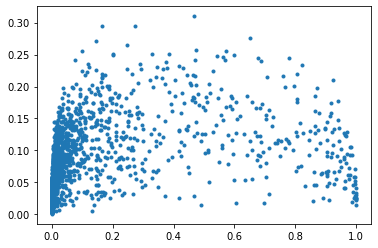

In [354]:
plt.scatter(np.abs(my_y_test - pred_test2), pred_conf2, marker='.')
plt.show()
plt.close()

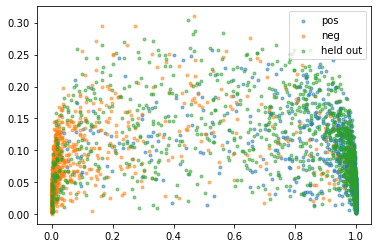

In [356]:
mask = (my_y_test == 1)
plt.scatter(pred_test2[mask], pred_conf2[mask], marker='.', alpha=0.5, label='pos')
mask = (my_y_test == 0)
plt.scatter(pred_test2[mask], pred_conf2[mask], marker='.', alpha=0.5, label='neg')
plt.scatter(pred_held_out[:1000], pred_held_out_conf[:1000], marker='.', alpha=0.5, label='held out')
plt.legend()
plt.show()
plt.close()

In [340]:
pearsonr(np.abs(my_y_test - pred_test2), pred_conf2)

(0.3964645894493566, 2.8785776309809253e-76)